In [22]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from tensorflow.keras.applications import VGG16, InceptionResNetV2
from keras import regularizers
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

In [23]:
train_dir = "../train" #passing the path with training images
test_dir = "../test"   #passing the path with testing images

In [24]:
img_size = 48

In [25]:
train_datagen = ImageDataGenerator(#rotation_range = 180,
                                         width_shift_range = 0.1,
                                         height_shift_range = 0.1,
                                         horizontal_flip = True,
                                         rescale = 1./255,
                                         #zoom_range = 0.2,
                                         validation_split = 0.2
                                        )
validation_datagen = ImageDataGenerator(rescale = 1./255,
                                         validation_split = 0.2)

In [26]:
train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (img_size,img_size),
                                                    batch_size = 64,
                                                    color_mode = "grayscale",
                                                    class_mode = "categorical",
                                                    subset = "training"
                                                   )
validation_generator = validation_datagen.flow_from_directory( directory = test_dir,
                                                              target_size = (img_size,img_size),
                                                              batch_size = 64,
                                                              color_mode = "grayscale",
                                                              class_mode = "categorical",
                                                              subset = "validation"
                                                                                         )

Found 22968 images belonging to 7 classes.
Found 1432 images belonging to 7 classes.


In [27]:
X_train, y_train = next(train_generator)
X_test, y_test = next(validation_generator)

In [28]:
len(train_generator)

359

In [18]:
X_train.shape

(64, 48, 48, 1)

In [19]:
y_train.shape

(64, 7)

In [20]:
X_test.shape

(64, 48, 48, 1)

In [21]:
y_test.shape

(64, 7)

In [29]:
class_names = train_generator.class_indices

class_names_swap = {v: k for k, v in class_names.items()}
print(class_names_swap)

{0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}


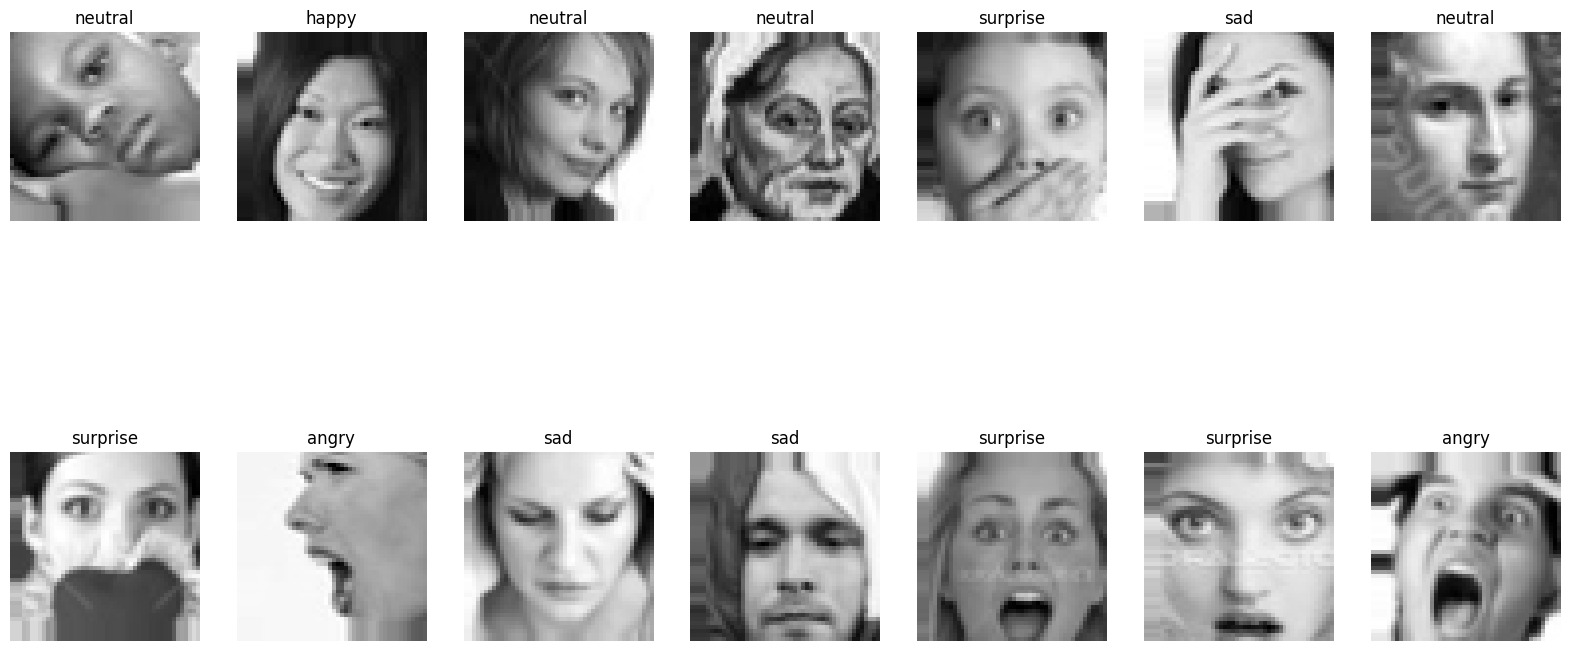

In [30]:
import random
import cv2
import matplotlib.pyplot as plt
import numpy as np 

r = random.sample(range(X_train.shape[0]), 14)
for i in range(14):
    plt.subplot(2, 7, i+1)
    plt.imshow(X_train[r[i]],'gray')
    plt.title(class_names_swap[np.argmax(y_train[r[i]])])
    plt.axis("off")    

In [31]:
from sklearn.utils import class_weight 
import numpy as np

class_weights = class_weight.compute_class_weight(
            class_weight = 'balanced',
            classes = np.unique(train_generator.classes), 
            y = train_generator.classes)

train_class_weights = dict(enumerate(class_weights))
# model.fit_generator(..., class_weight=train_class_weights)

In [32]:
train_class_weights

{0: 1.0266404434114071,
 1: 9.401555464592715,
 2: 1.0009587727708533,
 3: 0.5684585684585685,
 4: 0.826068191627104,
 5: 0.8491570541259982,
 6: 1.2933160650937552}

In [33]:
class_names_swap

{0: 'angry',
 1: 'disgust',
 2: 'fear',
 3: 'happy',
 4: 'neutral',
 5: 'sad',
 6: 'surprise'}

In [34]:
def identity_block(x, filter):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [35]:
def convolutional_block(x, filter):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same', strides = (2,2))(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Processing Residue with conv(1,1)
    x_skip = tf.keras.layers.Conv2D(filter, (1,1), strides = (2,2))(x_skip)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [36]:
def model_two(shape = (32, 32, 3), classes = 10):
    x_input = tf.keras.layers.Input(shape)
    x = tf.keras.layers.ZeroPadding2D((3, 3))(x_input)
    x = tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)
    
    x = identity_block(x, 64)
    x = identity_block(x, 64)
    x = identity_block(x, 64)
    x = convolutional_block(x, 128)
    x = tf.keras.layers.Dropout( 0.25)(x)
    x = identity_block(x, 128)
    x = identity_block(x, 128)
    x = identity_block(x, 128)
    x = convolutional_block(x, 256)
    x = tf.keras.layers.Dropout( 0.25)(x)
    x = identity_block(x, 256)
    x = identity_block(x, 256)
    x = identity_block(x, 256)
    x = identity_block(x, 256)
    x = tf.keras.layers.Dropout( 0.25)(x)
    x = identity_block(x, 256)
    x = identity_block(x, 256)
    x = identity_block(x, 256)
    x = convolutional_block(x, 512)
    x = tf.keras.layers.Dropout( 0.25)(x)
    x = identity_block(x, 512)
    x = identity_block(x, 512)
    x = identity_block(x, 512)
    x = identity_block(x, 512)
    x = tf.keras.layers.Dropout( 0.25)(x)
    x = identity_block(x, 512)
    
    x = tf.keras.layers.AveragePooling2D((2,2), padding = 'same')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation = 'relu')(x)
    x = tf.keras.layers.Dense(256, activation = 'relu')(x)
    x = tf.keras.layers.Dense(classes, activation = 'softmax')(x)
    model = tf.keras.models.Model(inputs = x_input, outputs = x, name = "model_two")
    return model

In [37]:
model = model_two(shape = (48, 48, 1), classes = 7)

epochs = 60
batch_size = 64
model.summary()

Model: "model_two"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 zero_padding2d_1 (ZeroPadding2  (None, 54, 54, 1)   0           ['input_2[0][0]']                
 D)                                                                                               
                                                                                                  
 conv2d_46 (Conv2D)             (None, 27, 27, 64)   3200        ['zero_padding2d_1[0][0]']       
                                                                                                  
 batch_normalization_43 (BatchN  (None, 27, 27, 64)  256         ['conv2d_46[0][0]']      

                                                                  'conv2d_55[0][0]']              
                                                                                                  
 activation_51 (Activation)     (None, 7, 7, 128)    0           ['add_24[0][0]']                 
                                                                                                  
 dropout_5 (Dropout)            (None, 7, 7, 128)    0           ['activation_51[0][0]']          
                                                                                                  
 conv2d_56 (Conv2D)             (None, 7, 7, 128)    147584      ['dropout_5[0][0]']              
                                                                                                  
 batch_normalization_52 (BatchN  (None, 7, 7, 128)   512         ['conv2d_56[0][0]']              
 ormalization)                                                                                    
          

 activation_60 (Activation)     (None, 4, 4, 256)    0           ['batch_normalization_60[0][0]'] 
                                                                                                  
 conv2d_66 (Conv2D)             (None, 4, 4, 256)    590080      ['activation_60[0][0]']          
                                                                                                  
 batch_normalization_61 (BatchN  (None, 4, 4, 256)   1024        ['conv2d_66[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 add_29 (Add)                   (None, 4, 4, 256)    0           ['batch_normalization_61[0][0]', 
                                                                  'dropout_6[0][0]']              
                                                                                                  
 activatio

                                                                                                  
 batch_normalization_70 (BatchN  (None, 4, 4, 256)   1024        ['conv2d_75[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_70 (Activation)     (None, 4, 4, 256)    0           ['batch_normalization_70[0][0]'] 
                                                                                                  
 conv2d_76 (Conv2D)             (None, 4, 4, 256)    590080      ['activation_70[0][0]']          
                                                                                                  
 batch_normalization_71 (BatchN  (None, 4, 4, 256)   1024        ['conv2d_76[0][0]']              
 ormalization)                                                                                    
          

 add_38 (Add)                   (None, 2, 2, 512)    0           ['batch_normalization_79[0][0]', 
                                                                  'activation_77[0][0]']          
                                                                                                  
 activation_79 (Activation)     (None, 2, 2, 512)    0           ['add_38[0][0]']                 
                                                                                                  
 conv2d_86 (Conv2D)             (None, 2, 2, 512)    2359808     ['activation_79[0][0]']          
                                                                                                  
 batch_normalization_80 (BatchN  (None, 2, 2, 512)   2048        ['conv2d_86[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

In [39]:
model.compile(
    optimizer = 'adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
  )

In [40]:
import scipy.integrate

import scipy.special
import scipy

history = model.fit(x = train_generator,epochs = 60,batch_size=batch_size,validation_data = validation_generator, class_weight=train_class_weights)

Epoch 1/60
359/359 [==============================] - 1443s 4s/step - loss: 2.0648 - accuracy: 0.1476 - val_loss: 1.9184 - val_accuracy: 0.1739
Epoch 2/60
359/359 [==============================] - 1387s 4s/step - loss: 1.9351 - accuracy: 0.1607 - val_loss: 1.9837 - val_accuracy: 0.1536
Epoch 3/60
359/359 [==============================] - 1382s 4s/step - loss: 1.9029 - accuracy: 0.2014 - val_loss: 1.8936 - val_accuracy: 0.2025
Epoch 4/60
359/359 [==============================] - 1382s 4s/step - loss: 1.8746 - accuracy: 0.2337 - val_loss: 1.9366 - val_accuracy: 0.2696
Epoch 5/60
359/359 [==============================] - 1385s 4s/step - loss: 1.8408 - accuracy: 0.2457 - val_loss: 1.8695 - val_accuracy: 0.2270
Epoch 6/60
359/359 [==============================] - 1383s 4s/step - loss: 1.8312 - accuracy: 0.2378 - val_loss: 1.8245 - val_accuracy: 0.2933
Epoch 7/60
359/359 [==============================] - 1383s 4s/step - loss: 1.7982 - accuracy: 0.2870 - val_loss: 1.9501 - val_accuracy:

KeyboardInterrupt: 

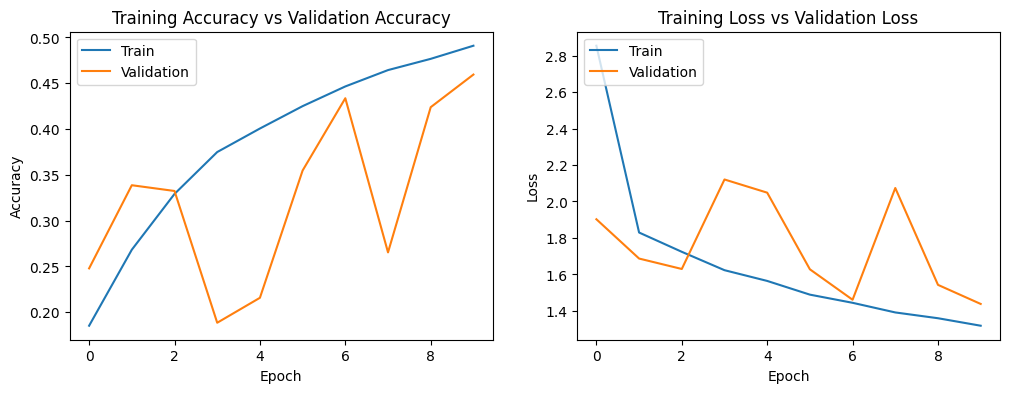

In [100]:
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [101]:
light_model.save('dropout_model.h5')